In [41]:
#Importing libararies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , confusion_matrix
import warnings
import math
import random
import scipy.stats
warnings.filterwarnings('ignore')

In [42]:
#Change the directory name
os.chdir('C:/Users/ssahi/Documents/ML_Course/Assignment_1')

## Data Preprocessing

In [43]:
#Reading the data
df = pd.read_csv("sgemm_product.csv")
df.shape

(241600, 18)

The data has 241600 records and 18 features

In [5]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


This data set measures the running time of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 261400 possible parameter combinations. 

For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds.

The first 14 features are the independent variables. The first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 261400 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

Therefore, we have 14 predictive attributes and 4 goal fields.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
MWG          241600 non-null int64
NWG          241600 non-null int64
KWG          241600 non-null int64
MDIMC        241600 non-null int64
NDIMC        241600 non-null int64
MDIMA        241600 non-null int64
NDIMB        241600 non-null int64
KWI          241600 non-null int64
VWM          241600 non-null int64
VWN          241600 non-null int64
STRM         241600 non-null int64
STRN         241600 non-null int64
SA           241600 non-null int64
SB           241600 non-null int64
Run1 (ms)    241600 non-null float64
Run2 (ms)    241600 non-null float64
Run3 (ms)    241600 non-null float64
Run4 (ms)    241600 non-null float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [7]:
#Checking for missing values
df.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

There are no missing values

In [44]:
#Taking the average of runs for target variable
df["avg_run"] = df.iloc[:,14:].mean(axis = 1)

In [45]:
#Dropping the four Run columns
df.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], axis = 1, inplace = True)

df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_run
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


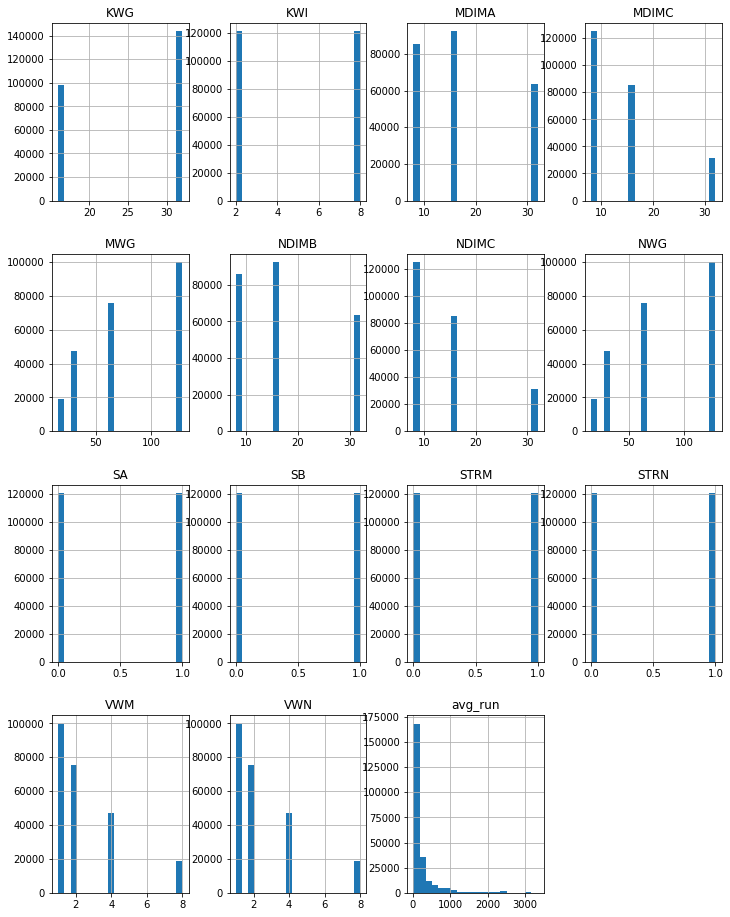

In [36]:
# Histogram of all the features to understand the distribution
df.hist(bins = 20 , figsize= (12,16)) ;

We see that the avg_run target variable is right-skewed. We can correct this by taking the logarithmic transformation of the target variable and using that instead.

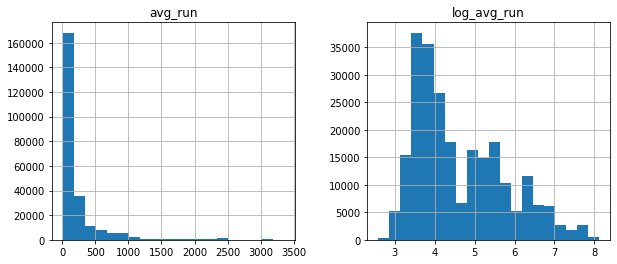

In [46]:
#Taking log of the Average run times
df["log_avg_run"] = np.log(df.avg_run) 

plt.rcParams['figure.figsize'] = (10, 4)
run_time_cols = ["avg_run","log_avg_run"]
run_times=df[run_time_cols]
run_times.hist(bins = 20) ;

As we observe, the logarithmic transformation is giving us a more normally distributed function. Therefore, we will drop avg_run column and use the log_avg_run column as target variable.

In [47]:
#Dropping the Average run column
df.drop(['avg_run'], axis = 1, inplace = True)

Text(0.5, 1.0, 'Average Run Time distribution')

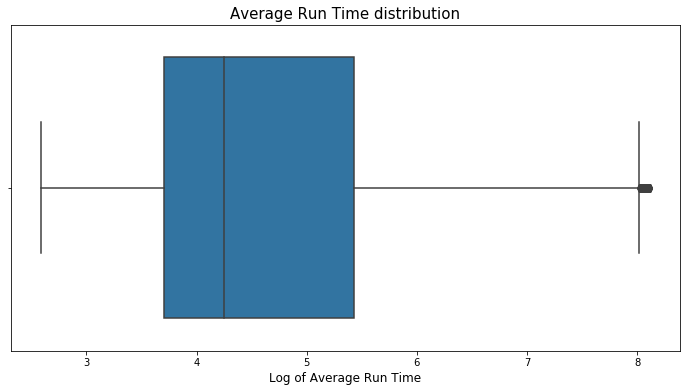

In [13]:
# Find outliers
plt.rcParams['figure.figsize'] = (12, 6)
sns.boxplot(x="log_avg_run", data=df)
plt.xlabel('Log of Average Run Time', fontsize=12)
plt.title("Average Run Time distribution", fontsize=15)

We see that there are some outlier values in the target column. We can delete these rows as the number of these rows is a very low percentage of the total rows.

In [48]:
#Deleting outliers
df = df[df['log_avg_run'] <= 8]

## Scaling and Dividing into Training and Test Sets

In [49]:
#Normalize using StandardScaler function
sc_data = StandardScaler()
LineReg = sc_data.fit_transform(df)
LineReg = pd.DataFrame(LineReg)
LineReg.columns = ['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI',
       'VWM', 'VWN', 'STRM', 'STRN', 'SA', 'SB', 'log_avg_run']

In [50]:
LineReg.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,log_avg_run
0,-1.514916,-1.514916,-1.208972,-0.755071,-0.755071,-0.998068,-0.99807,-0.998011,-0.741098,-0.741098,-1.000017,-1.000017,-0.998011,-0.998011,0.125565
1,-1.514916,-1.514916,-1.208972,-0.755071,-0.755071,-0.998068,-0.99807,-0.998011,-0.741098,-0.741098,-1.000017,-1.000017,-0.998011,1.001993,-0.223847
2,-1.514916,-1.514916,-1.208972,-0.755071,-0.755071,-0.998068,-0.99807,-0.998011,-0.741098,-0.741098,-1.000017,-1.000017,1.001993,-0.998011,-0.202978
3,-1.514916,-1.514916,-1.208972,-0.755071,-0.755071,-0.998068,-0.99807,-0.998011,-0.741098,-0.741098,-1.000017,-1.000017,1.001993,1.001993,-0.138050
4,-1.514916,-1.514916,-1.208972,-0.755071,-0.755071,-0.998068,-0.99807,-0.998011,-0.741098,-0.741098,-1.000017,0.999983,-0.998011,-0.998011,0.142995


In [51]:
#Setting the matrixes

# X is the feature matrix with all the 14 independent features and the first column as all 1s for the intercept cofficient
X = LineReg.iloc[:,0:14]
ones = np.ones([X.shape[0],1])
X = np.concatenate((ones,X),axis=1)

# Y is the target variable matrix with just one column
Y = LineReg.iloc[:,14:].values 

# Initialising the beta values with all zeroes.
beta_strt = np.zeros([1,15])

print("Shape of Feature matrix:", X.shape)
print("Shape of Target matrix:", Y.shape)
print("Initial beta values:", beta_strt)

Shape of Feature matrix: (241120, 15)
Shape of Target matrix: (241120, 1)
Initial beta values: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [52]:
X

array([[ 1.        , -1.5149157 , -1.5149157 , ..., -1.00001659,
        -0.99801127, -0.99801127],
       [ 1.        , -1.5149157 , -1.5149157 , ..., -1.00001659,
        -0.99801127,  1.0019927 ],
       [ 1.        , -1.5149157 , -1.5149157 , ..., -1.00001659,
         1.0019927 , -0.99801127],
       ...,
       [ 1.        ,  1.12297108,  1.12297108, ...,  0.99998341,
        -0.99801127,  1.0019927 ],
       [ 1.        ,  1.12297108,  1.12297108, ...,  0.99998341,
         1.0019927 , -0.99801127],
       [ 1.        ,  1.12297108,  1.12297108, ...,  0.99998341,
         1.0019927 ,  1.0019927 ]])

In [53]:
Y

array([[ 0.12556464],
       [-0.22384737],
       [-0.20297777],
       ...,
       [-0.94381245],
       [-1.13293835],
       [-1.55113665]])

In [54]:
beta_strt

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [55]:
#Splitting the data into training and test set by 80-20 division
X_train_exp1,X_test_exp1,y_train_exp1,y_test_exp1 = train_test_split(X,Y,test_size = 0.2,random_state = 0)

## Linear Regression Functions

In [15]:
#Calculate cost
def calculateCost(X,Y,beta):
    summation = np.power(((X @ beta.T)-Y),2)
    finalCost = np.sum(summation)/(2 * len(X))
    return finalCost

In [16]:
#Implement batch gradient descent with no convergence threshold and fixed iterations
def gradientDescent(X,Y,beta,iters,alpha):
    cost = np.zeros(iters)
    diff = 1
    convg = 0
    for i in range(iters):
        beta = beta - (alpha/len(X)) * np.sum(X * (X @ beta.T - Y), axis=0)
        cost[i] = calculateCost(X, Y, beta)
        if diff > 0.0000001:    
            if i==0:
                diff = cost[i]
            else:
                diff = abs(cost[i] - cost[i-1])
                if diff <= 0.0000001:
                    convg = i
    return beta,cost,convg

In [17]:
#Implement batch gradient descent with convergence threshold as input
def gradientDescentThresh(X,Y,beta,alpha,thresh,iters=5000):
    cost = []
    diff = 1
    convg = 0
    while diff > thresh:
        beta = beta - (alpha/len(X)) * np.sum(X * (X @ beta.T - Y), axis=0)
        cost.append(calculateCost(X, Y, beta))
        if len(cost)==1:
            diff = cost[0]
        else:
            diff = abs(cost[-1] - cost[-2])
            if diff <= thresh:
                convg = len(cost)
    return beta,cost,convg

In [18]:
#Implement batch gradient descent with convergence threshold as input
#Calculate Test and Train dataset MSE at each iteration
def gradientDescentItersMSE(X,Y,X_test,Y_test,beta,alpha,thresh,iters=5000):
    Test_err = []
    Train_err = []
    cost = []
    diff = 1
    convg = 0
    while diff > thresh:
        beta = beta - (alpha/len(X)) * np.sum(X * (X @ beta.T - Y), axis=0)
        cost.append(calculateCost(X, Y, beta))
        
        y_hat_test = predict(X_test,beta)
        y_hat_train = predict(X,beta)
        
        Test_MSE = calculateMSE(Y_test,y_hat_test)
        Train_MSE = calculateMSE(Y,y_hat_train)
        
        Test_err.append(Test_MSE)
        Train_err.append(Train_MSE)
        
        if len(cost)==1:
            diff = cost[0]
        else:
            diff = abs(cost[-1] - cost[-2])
            if diff <= thresh:
                convg = len(cost)
    return Test_err,Train_err,convg

In [19]:
#Calculate predicted Y
def predict(X,beta):
    Y_hat = X.dot(beta.T)
    return Y_hat

In [20]:
#Calculate MSE
def calculateMSE(Y, Y_hat):
    MSE = (np.sum((Y - Y_hat) ** 2) / len(Y));
    return MSE;

In [21]:
#Calculate R-squared
def calculateRSquared(Y, Y_hat):
    Y_mean = np.mean(Y)
    residualSSE = np.sum((Y - Y_hat) ** 2)
    totalSSE = np.sum((Y - Y_mean) ** 2)
    rSquared = 1 - (residualSSE / totalSSE)
    return rSquared

In [22]:
def printResults(X,Y,X_test,Y_test,beta,iters,alpha):
    print("Alpha:",alpha)
    beta_cal,cost_cal,convg_cal = gradientDescent(X,Y,beta,iters,alpha)
    
    print("The beta values are:",beta_cal)
    print("The final value of cost function is:", cost_cal[-1])
    print("The value of cost function converges at:", convg_cal)

    plt.plot(cost_cal) 
    plt.xlabel("Number of iterations") 
    plt.ylabel("Cost") 
    plt.title("Cost Converging wrt Iterations")
    plt.show()
    
    #Calculating MSE for test and train data
    y_hat_test = predict(X_test,beta_cal)
    y_hat_train = predict(X,beta_cal)
    
    Test_MSE = calculateMSE(Y_test,y_hat_test)
    Train_MSE = calculateMSE(Y,y_hat_train)
    
    print("Test data MSE: ",Test_MSE)
    print("Train data MSE: ",Train_MSE)
    
    #Calculating R-squared for test and train data
    print("Test data R-squared: ",calculateRSquared(Y_test,y_hat_test))
    print("Train data R-squared: ",calculateRSquared(Y,y_hat_train))

## Experiment 1 - Running the model with different alpha values and fixed iterations

In [56]:
#Compute cost with all Betas as zeroes
Cost_without_GD = calculateCost(X_train_exp1, y_train_exp1, beta_strt)
print(Cost_without_GD)

0.49950084316227295


In [57]:
#The values of alphas we will derive result for
alpha_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 1.3, 1.5]

In [58]:
#Setting the figure size and the number of iteartions
plt.rcParams['figure.figsize'] = (8, 6)
iters = 2000

Alpha: 0.001
The beta values are: [[ 1.60548825e-04  3.92378292e-01  3.03259783e-01  2.73316605e-02
  -2.71634428e-01 -2.61189747e-01 -2.48865256e-03 -8.42029673e-03
  -1.27135362e-02  6.34989264e-02  2.93817676e-02 -5.22090024e-02
  -6.72089961e-03 -7.74027752e-02 -2.21091603e-02]]
The final value of cost function is: 0.23846815436162794
The value of cost function converges at: 0


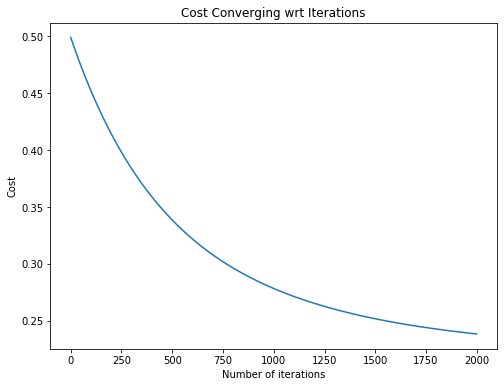

Test data MSE:  0.4776721345415939
Train data MSE:  0.4769363087232559
Test data R-squared:  0.5242265348964357
Train data R-squared:  0.5225870071461345


In [59]:
alpha = 0.001
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 0.005
The beta values are: [[ 4.13240949e-04  5.00518303e-01  3.94904525e-01  8.27421539e-02
  -3.93911612e-01 -3.79025918e-01  1.00242963e-03 -1.31018699e-03
  -1.35482415e-02 -1.42997634e-02 -4.02714457e-02 -6.06305001e-02
  -7.89946884e-03 -8.84339932e-02 -2.43616981e-02]]
The final value of cost function is: 0.22105959200415695
The value of cost function converges at: 1698


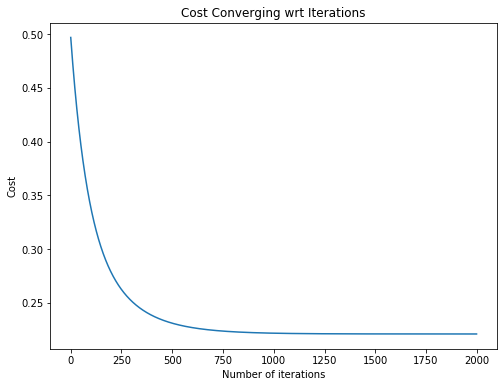

Test data MSE:  0.4428075654469661
Train data MSE:  0.4421191840083139
Test data R-squared:  0.5589525229706873
Train data R-squared:  0.5574389305763798


In [60]:
alpha = 0.005
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 0.01
The beta values are: [[ 4.15195167e-04  5.02029449e-01  3.96233251e-01  8.37052574e-02
  -3.95654604e-01 -3.80718358e-01  8.82079479e-04 -1.30996379e-03
  -1.35300278e-02 -1.58533432e-02 -4.16314992e-02 -6.06404830e-02
  -7.90482126e-03 -8.84169664e-02 -2.43418230e-02]]
The final value of cost function is: 0.2210556120515606
The value of cost function converges at: 914


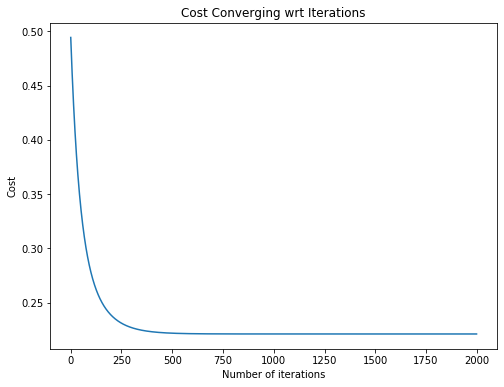

Test data MSE:  0.44280343777024683
Train data MSE:  0.4421112241031212
Test data R-squared:  0.5589566342405595
Train data R-squared:  0.5574468984372689


In [61]:
alpha = 0.01
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 0.05
The beta values are: [[ 4.15204142e-04  5.02038339e-01  3.96241041e-01  8.37098923e-02
  -3.95663395e-01 -3.80726855e-01  8.80555023e-04 -1.31074101e-03
  -1.35299340e-02 -1.58625051e-02 -4.16394896e-02 -6.06405266e-02
  -7.90484961e-03 -8.84168566e-02 -2.43417099e-02]]
The final value of cost function is: 0.2210556119321399
The value of cost function converges at: 212


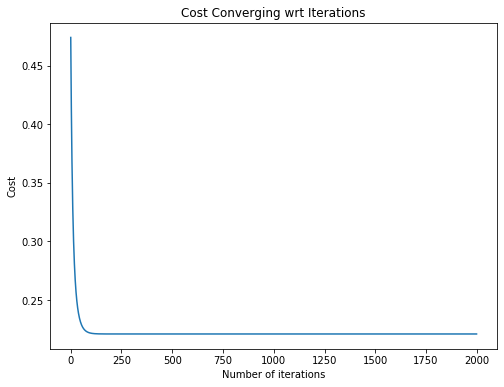

Test data MSE:  0.44280345558540324
Train data MSE:  0.4421112238642798
Test data R-squared:  0.5589566164962154
Train data R-squared:  0.557446898676349


In [62]:
alpha = 0.05
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 0.1
The beta values are: [[ 4.15204142e-04  5.02038339e-01  3.96241041e-01  8.37098923e-02
  -3.95663395e-01 -3.80726855e-01  8.80555023e-04 -1.31074101e-03
  -1.35299340e-02 -1.58625051e-02 -4.16394896e-02 -6.06405266e-02
  -7.90484961e-03 -8.84168566e-02 -2.43417099e-02]]
The final value of cost function is: 0.2210556119321399
The value of cost function converges at: 111


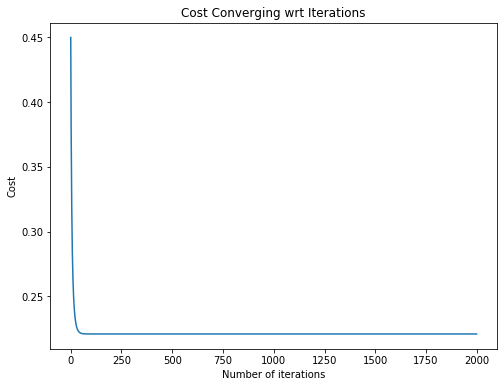

Test data MSE:  0.44280345558540324
Train data MSE:  0.4421112238642798
Test data R-squared:  0.5589566164962154
Train data R-squared:  0.557446898676349


In [63]:
alpha = 0.1
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 0.3
The beta values are: [[ 4.15204142e-04  5.02038339e-01  3.96241041e-01  8.37098923e-02
  -3.95663395e-01 -3.80726855e-01  8.80555023e-04 -1.31074101e-03
  -1.35299340e-02 -1.58625051e-02 -4.16394896e-02 -6.06405266e-02
  -7.90484961e-03 -8.84168566e-02 -2.43417099e-02]]
The final value of cost function is: 0.2210556119321399
The value of cost function converges at: 38


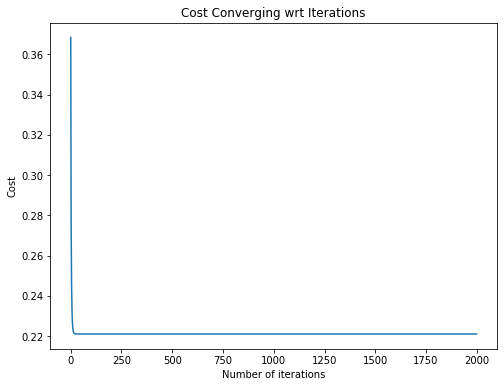

Test data MSE:  0.44280345558540324
Train data MSE:  0.4421112238642798
Test data R-squared:  0.5589566164962154
Train data R-squared:  0.557446898676349


In [64]:
alpha = 0.3
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 1
The beta values are: [[ 4.15204142e-04  5.02038339e-01  3.96241041e-01  8.37098923e-02
  -3.95663395e-01 -3.80726855e-01  8.80555023e-04 -1.31074101e-03
  -1.35299340e-02 -1.58625051e-02 -4.16394896e-02 -6.06405266e-02
  -7.90484961e-03 -8.84168566e-02 -2.43417099e-02]]
The final value of cost function is: 0.2210556119321399
The value of cost function converges at: 10


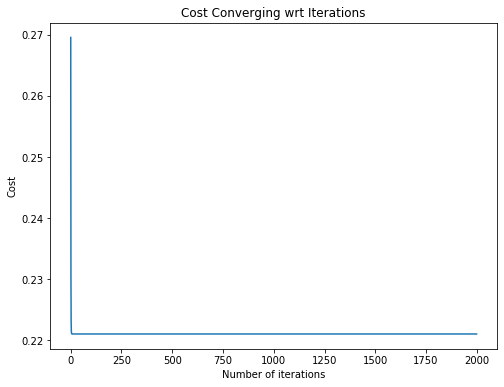

Test data MSE:  0.44280345558540324
Train data MSE:  0.4421112238642798
Test data R-squared:  0.5589566164962154
Train data R-squared:  0.557446898676349


In [65]:
alpha = 1
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 1.3
The beta values are: [[ 4.15204142e-04  5.02038339e-01  3.96241041e-01  8.37098923e-02
  -3.95663395e-01 -3.80726855e-01  8.80555023e-04 -1.31074101e-03
  -1.35299340e-02 -1.58625051e-02 -4.16394896e-02 -6.06405266e-02
  -7.90484961e-03 -8.84168566e-02 -2.43417099e-02]]
The final value of cost function is: 0.2210556119321399
The value of cost function converges at: 37


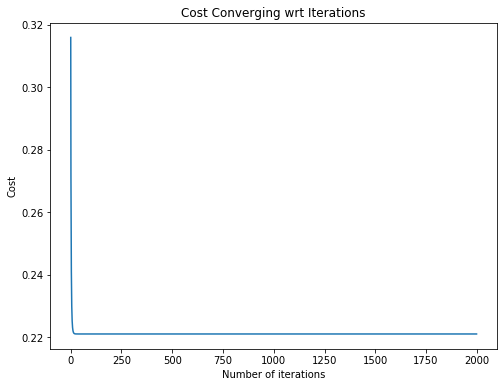

Test data MSE:  0.44280345558540324
Train data MSE:  0.4421112238642798
Test data R-squared:  0.5589566164962154
Train data R-squared:  0.557446898676349


In [66]:
alpha = 1.3
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

Alpha: 1.5
The beta values are: [[ 3.03831620e+109 -2.96668187e+110 -2.81748867e+110  1.27480922e+111
   2.29226655e+111  2.46702306e+111  3.52174032e+111  3.59171604e+111
   3.08886062e+109 -2.77141984e+111 -2.85361374e+111 -1.37020508e+108
   1.06329725e+109 -1.94999303e+108  1.36494223e+109]]
The final value of cost function is: 3.867536797091167e+223
The value of cost function converges at: 0


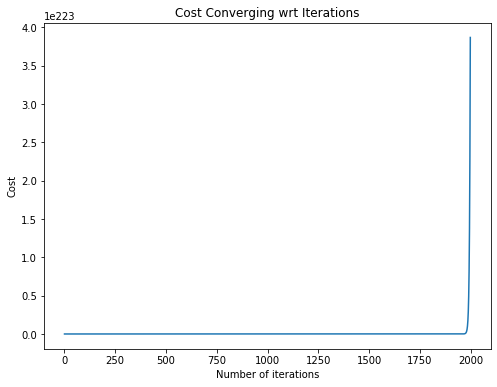

Test data MSE:  7.735193071422918e+223
Train data MSE:  7.735073594182333e+223
Test data R-squared:  -7.704446930670825e+223
Train data R-squared:  -7.742804577888135e+223


In [67]:
alpha = 1.5
printResults(X_train_exp1,y_train_exp1,X_test_exp1,y_test_exp1,beta_strt,iters,alpha)

## Experiment 2 - Varying the values of convergence threshold

In [68]:
cvng_thresh = [0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001,0.00000000001,0.000000000001]
Test_MSE = []
Train_MSE = []
GD_iters = []
alpha = 0.05
for i in cvng_thresh:
    beta_cal,cost_cal,convg_cal = gradientDescentThresh(X_train_exp1,y_train_exp1,beta_strt,alpha,i)
    
    y_hat_test = predict(X_test_exp1,beta_cal)
    y_hat_train = predict(X_train_exp1,beta_cal)
    
    Test_MSE_i = calculateMSE(y_test_exp1,y_hat_test)
    Train_MSE_i = calculateMSE(y_train_exp1,y_hat_train)
    
    Test_MSE.append(Test_MSE_i)
    Train_MSE.append(Train_MSE_i)
    GD_iters.append(convg_cal)

Text(0.5, 1.0, 'Test Data MSE as a function of Threshold')

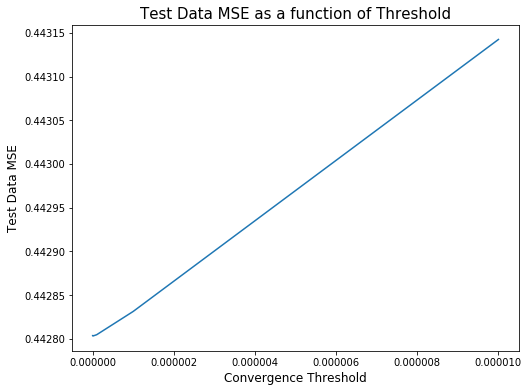

In [69]:
plt.plot(cvng_thresh, Test_MSE)
plt.xlabel('Convergence Threshold', fontsize=12)
plt.ylabel('Test Data MSE', fontsize=12)
plt.title('Test Data MSE as a function of Threshold', fontsize=15)

Text(0.5, 1.0, 'Train Data MSE as a function of Threshold')

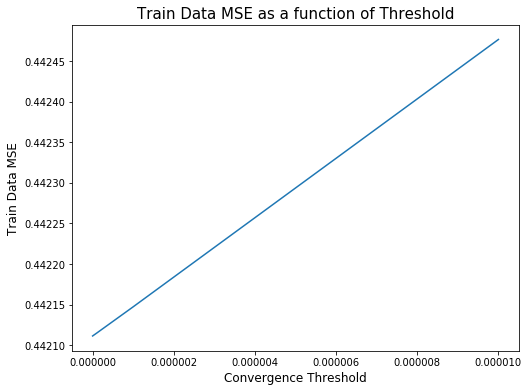

In [70]:
plt.plot(cvng_thresh, Train_MSE)
plt.xlabel('Convergence Threshold', fontsize=12)
plt.ylabel('Train Data MSE', fontsize=12)
plt.title('Train Data MSE as a function of Threshold', fontsize=15)

In [79]:
Test_MSE

[0.44314243390152036,
 0.4428311221661564,
 0.44280446516646665,
 0.442803031676418,
 0.4428032510195214,
 0.4428033859624052,
 0.4428034337084782,
 0.4428034488752369]